In [1]:
import os
import glob
import shutil
import random
import matplotlib
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import os.path as osp
import seaborn as sns
import os.path as osp
from typing import Dict, Any
from plottable.cmap import normed_cmap
import matplotlib.pyplot as plt
from matplotlib.cm import Greens, Reds

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from plottable import ColumnDefinition
from plottable import Table
from plottable.formatters import decimal_to_percent
from configs.general import EXPERIMENT_INFO_PATH, BASE_DIR,\
      EXPERIMENT_BASE_DIR, EXPERIMENT_COLS, DATA_FILTERING_POLICIES,\
          DATA_RETRIEVAL_POLICIES, PHASES, FILTERING_EXPERIMENT_COLS,\
          FILTERING_EXPERIMENT_BASE_DIR, FILTERING_EXPERIMENT_INFO_PATH, METRICS_BASE_DIR

from metric.level2.correctness import Correctness
from utils.plot import draw_stacked_bars

scaler = MinMaxScaler()

from utils.metrics import load_experiments

from metric.level2.loss import Loss
from metric.level2.entropy import Entropy
from metric.level2.top_proba import TopProba
from metric.level2.aum import AreaUnderMargin
from metric.level2.id2m import IntegralDiff2Max
from metric.level2.correctness import Correctness

AVAILABLE_METRICS : Dict[str, Any] = {
    "correctness": Correctness,
    "entropy": Entropy,
    "id2m": IntegralDiff2Max,
    "loss": Loss,
    "top_proba": TopProba,
    "aum": AreaUnderMargin
}
MEANSTD_METRIC = ["top_proba", "entropy", "loss"]


In [2]:
metric_auc_files = {metric_name: osp.join(METRICS_BASE_DIR, f"{metric_name}_auc.csv") for metric_name in AVAILABLE_METRICS.keys()}

## Plot AUC all experiments

In [3]:
experiments = load_experiments(EXPERIMENT_INFO_PATH, index_col='index')
valid_experiments = experiments[(experiments['done'] == True) & (experiments['valid'] == True)]
metric_auc_dataframes = {metric_name: pd.read_csv(path).drop(columns=['dataset','model','dropout','optim','lr','lr_scheduler','init','transform','np','ns','folds','epochs','done','valid','train_loss','validation_loss']) for metric_name, path in metric_auc_files.items()}

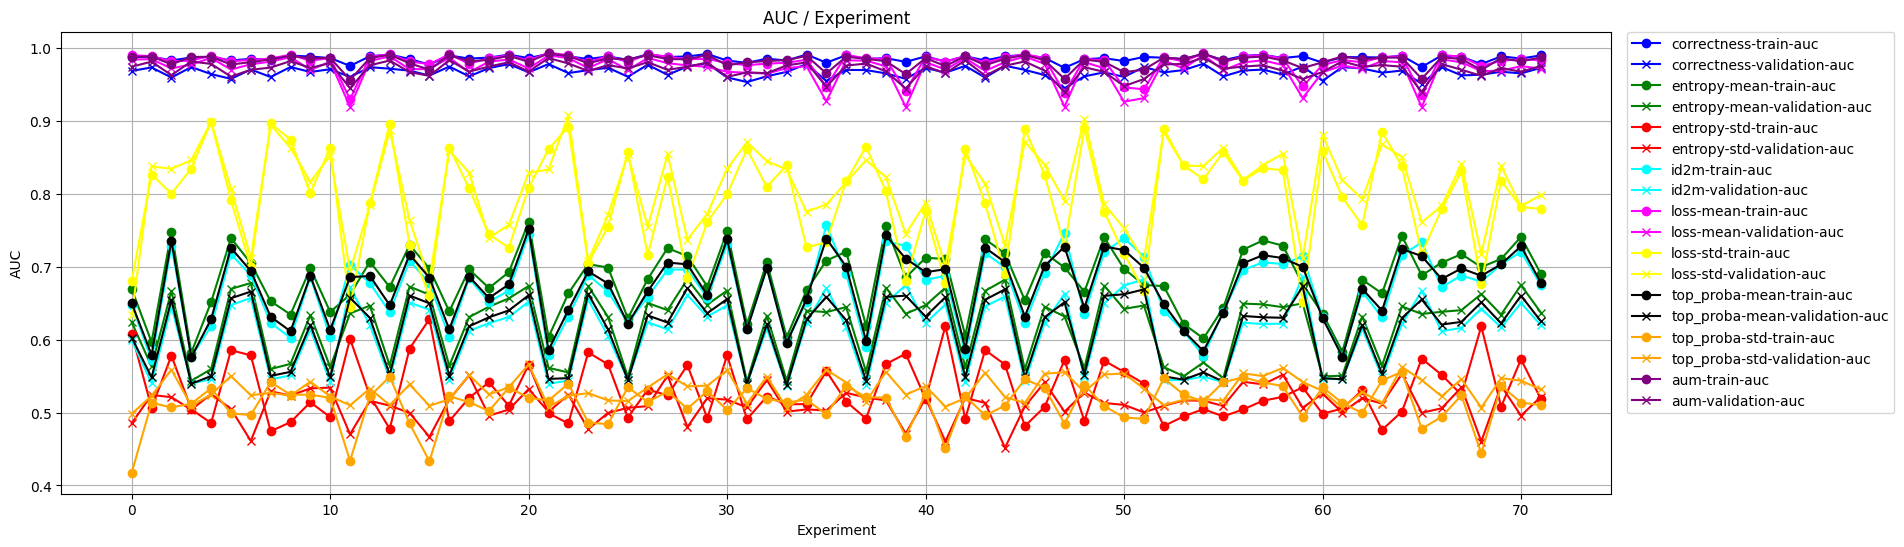

In [4]:
from functools import reduce
merged_metrics_auc = reduce(lambda left, right: pd.merge(left, right, on='index'), metric_auc_dataframes.values())

# Transform the columns based on the mean condition
for column in merged_metrics_auc.columns:
    if column != 'index':
        if merged_metrics_auc[column].mean() < 0.5:
            merged_metrics_auc[column] = 1 - merged_metrics_auc[column]

colors = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 
    'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 
    'maroon', 'navy', 'lime', 'teal', 'aqua', 'fuchsia', 'silver'
]

# Plotting
plt.figure(figsize=(20, 6))

# Plot each value column
for i, column in enumerate(merged_metrics_auc.columns):
    if column != 'index':
        if column.find("val") == -1:
            marker='o'
        else:
            marker='x'

        plt.plot(list(range(len(merged_metrics_auc['index']))), merged_metrics_auc[column], marker=marker, label=column, color=colors[((i-1)//2)])

plt.xlabel('Experiment')
plt.ylabel('AUC')
plt.title('AUC / Experiment')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()

# Plot Contributions

In [5]:
metric_dataframes = {metric_name: pd.read_csv(path) for metric_name, path in metric_auc_files.items()}

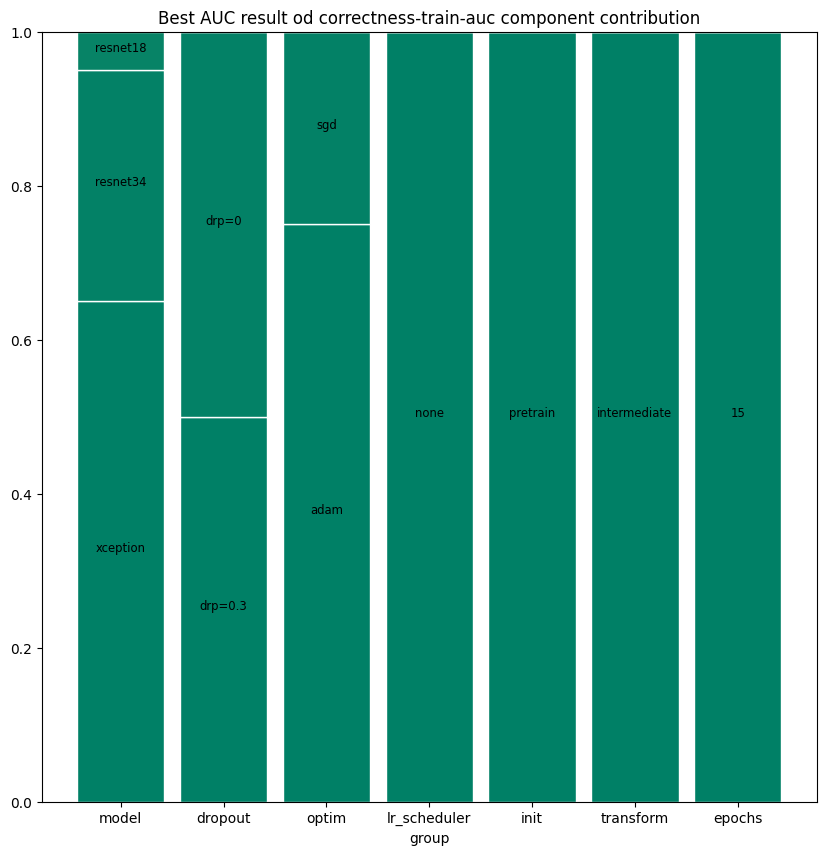

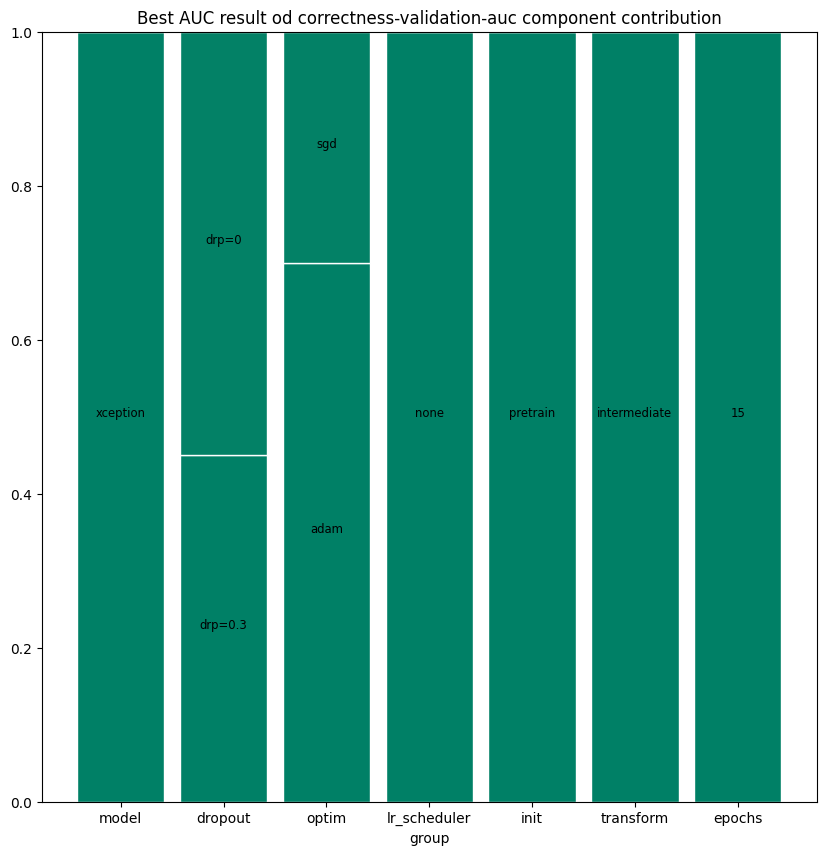

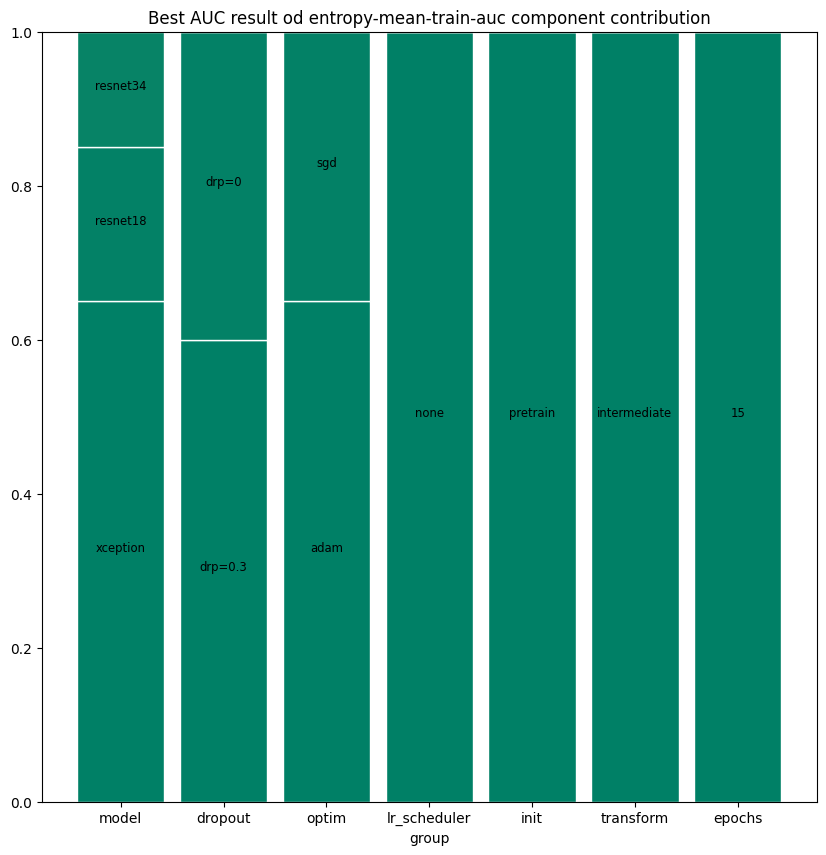

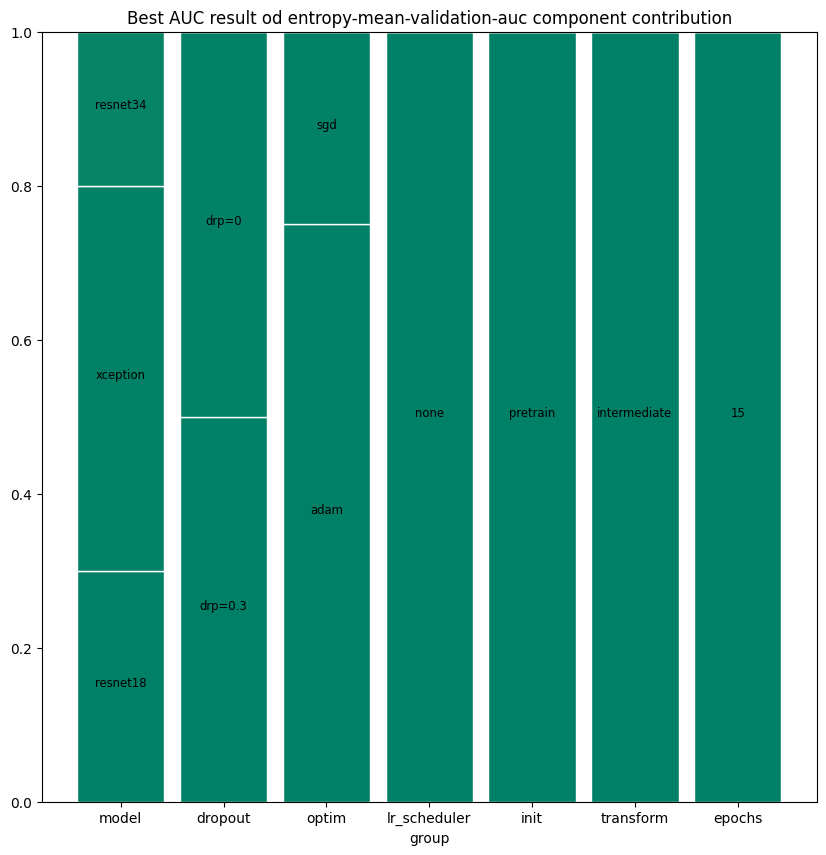

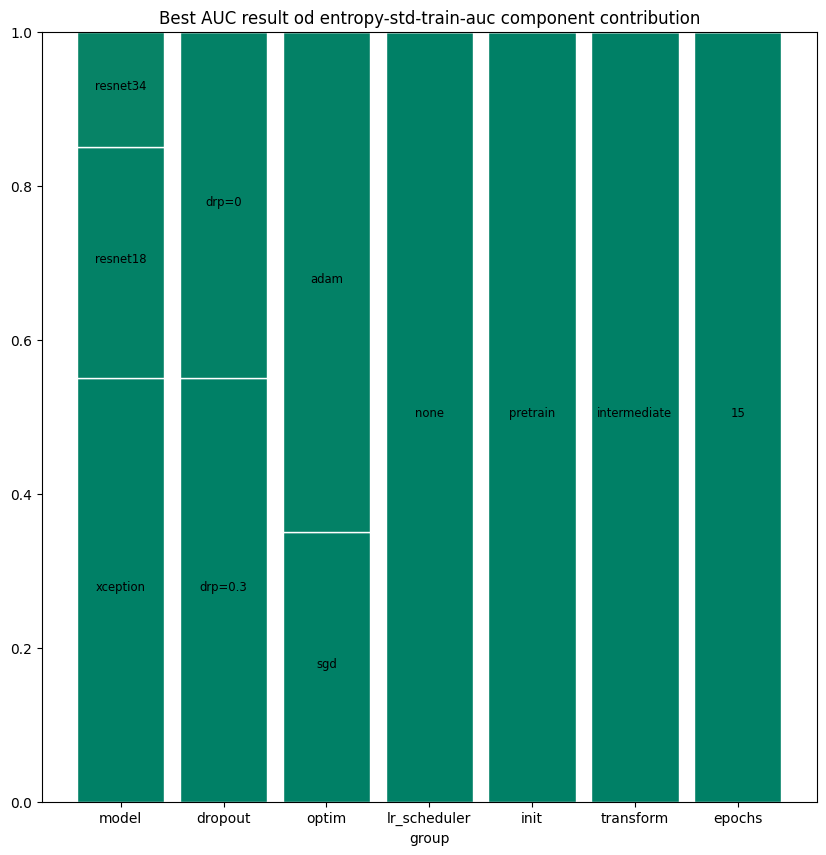

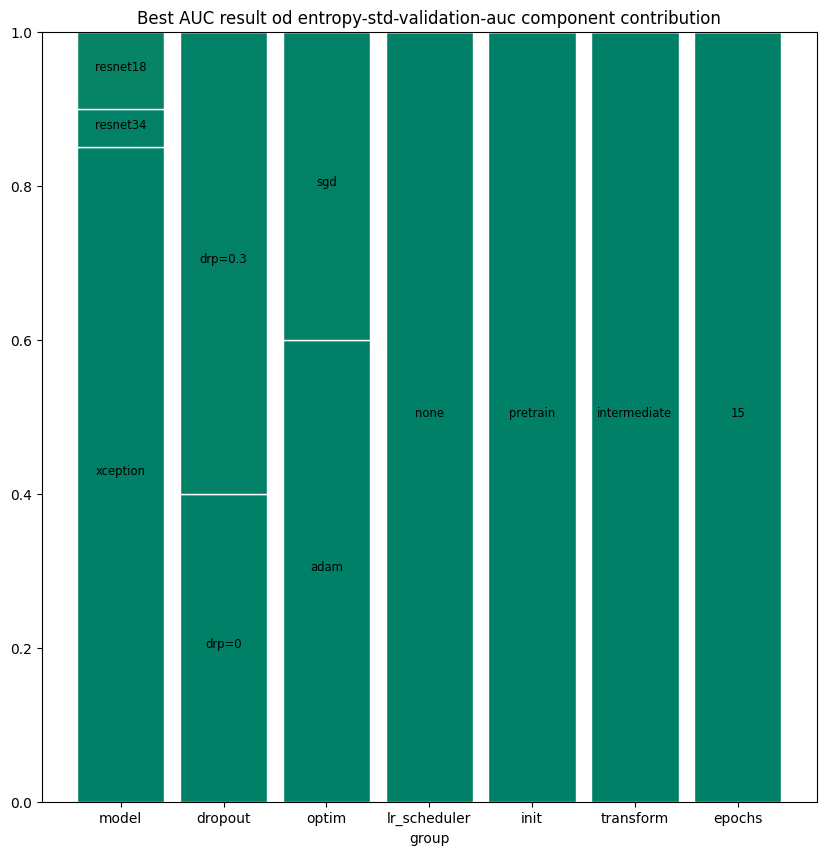

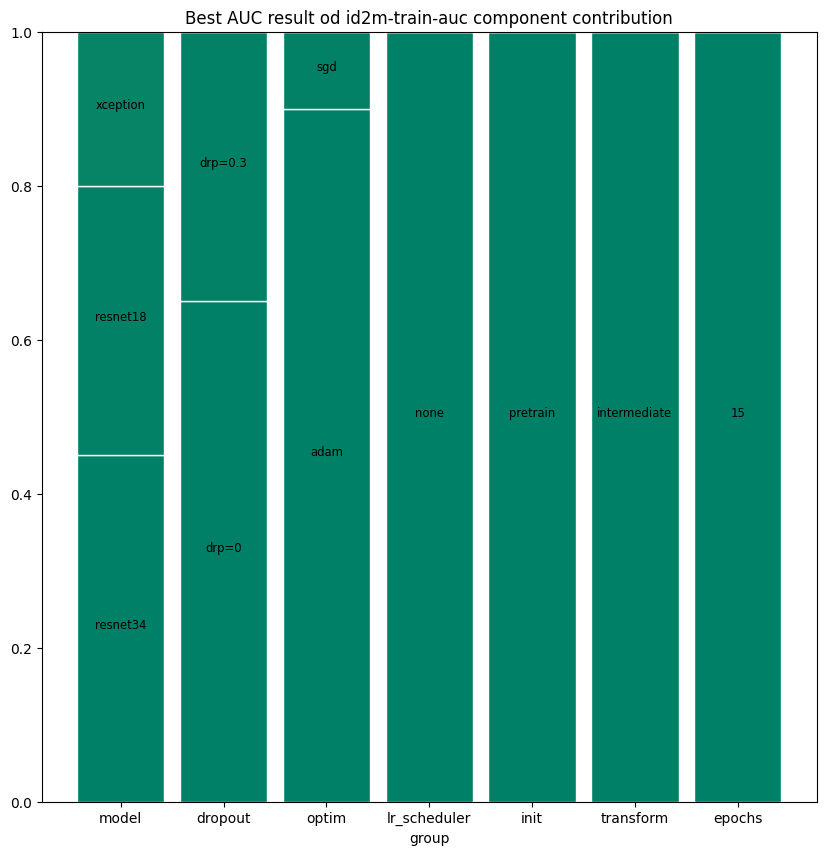

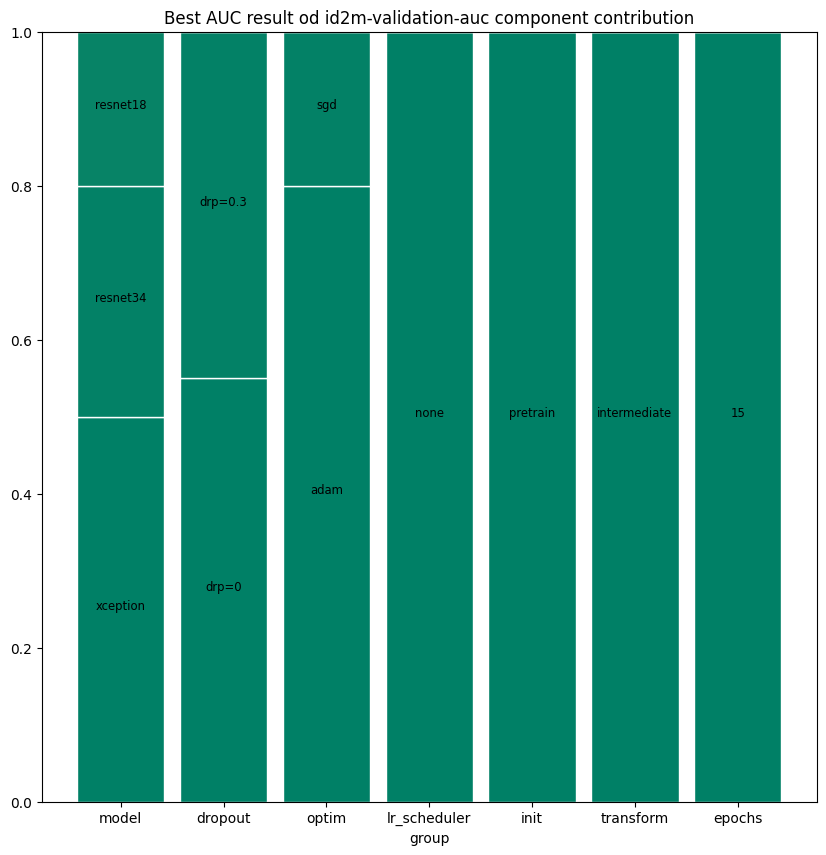

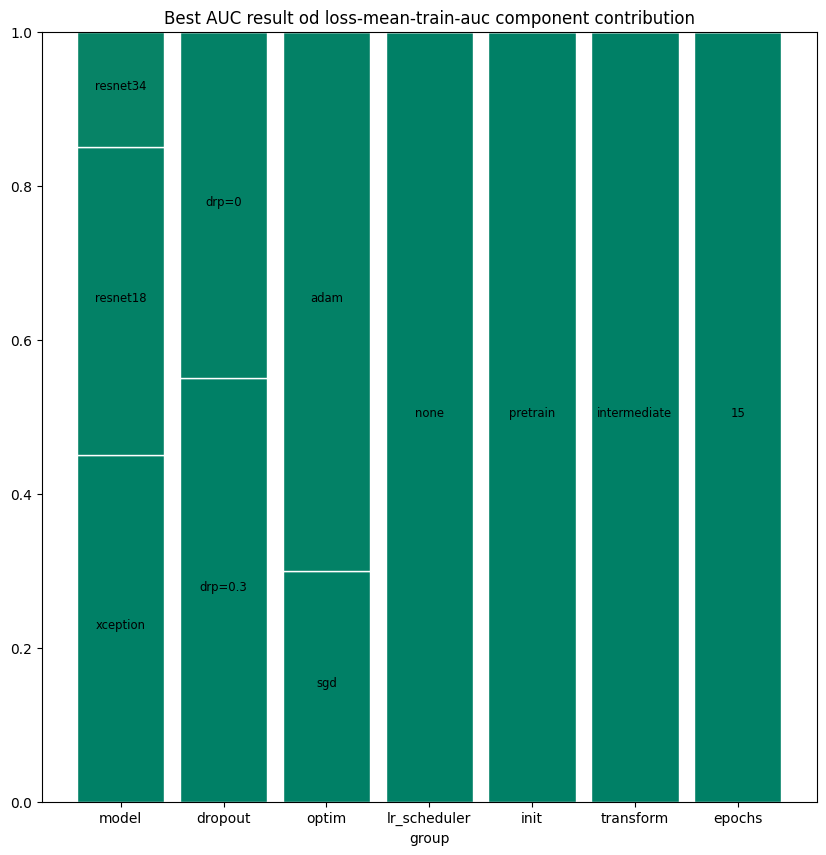

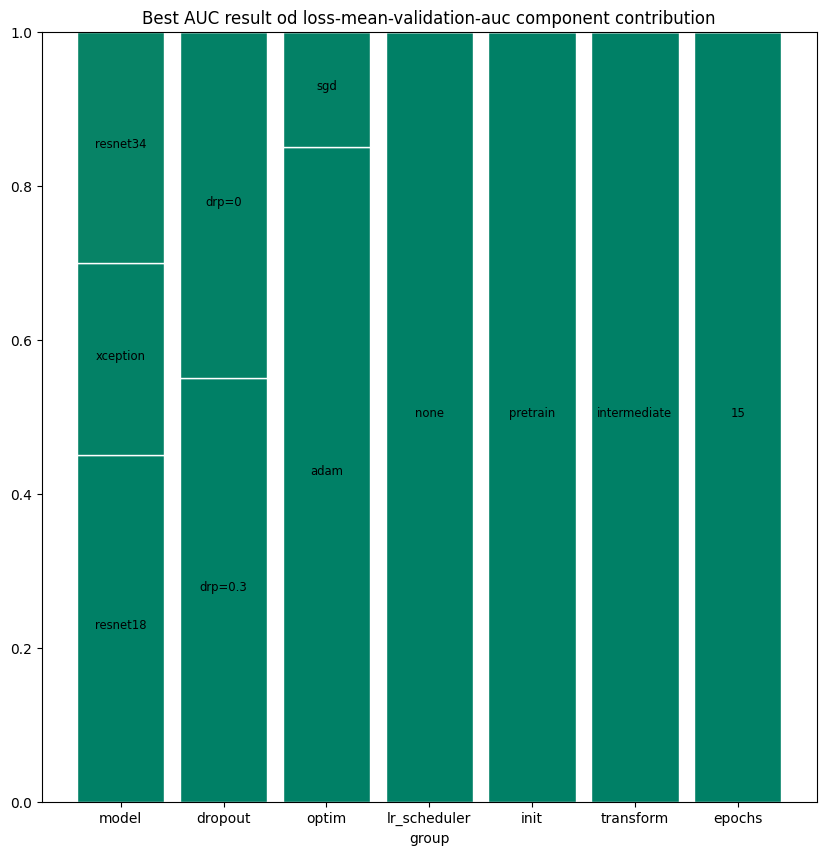

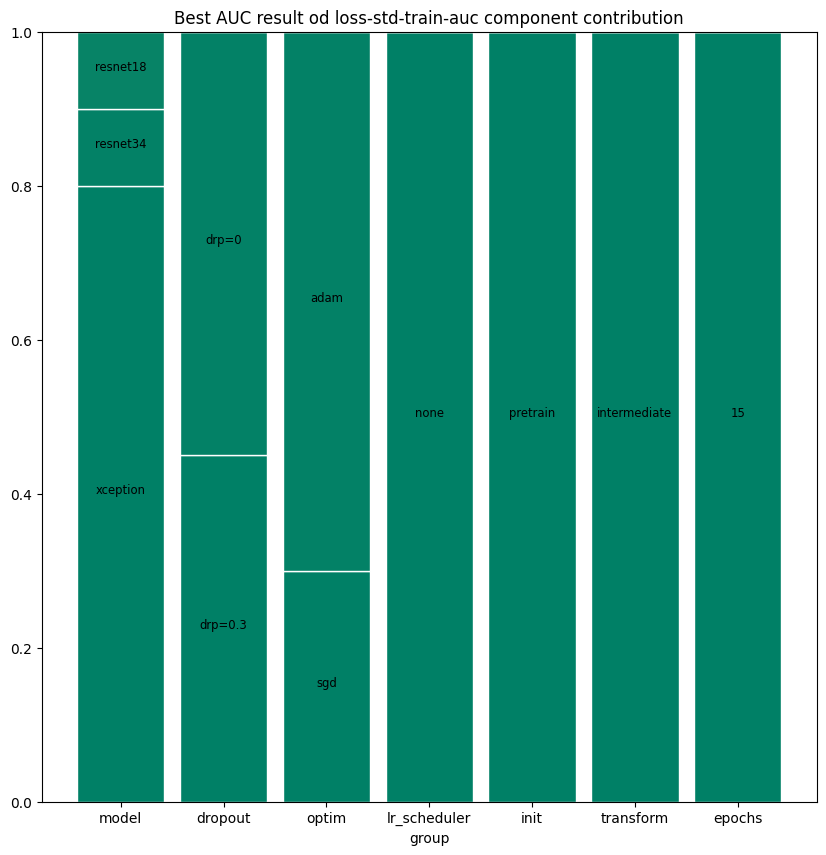

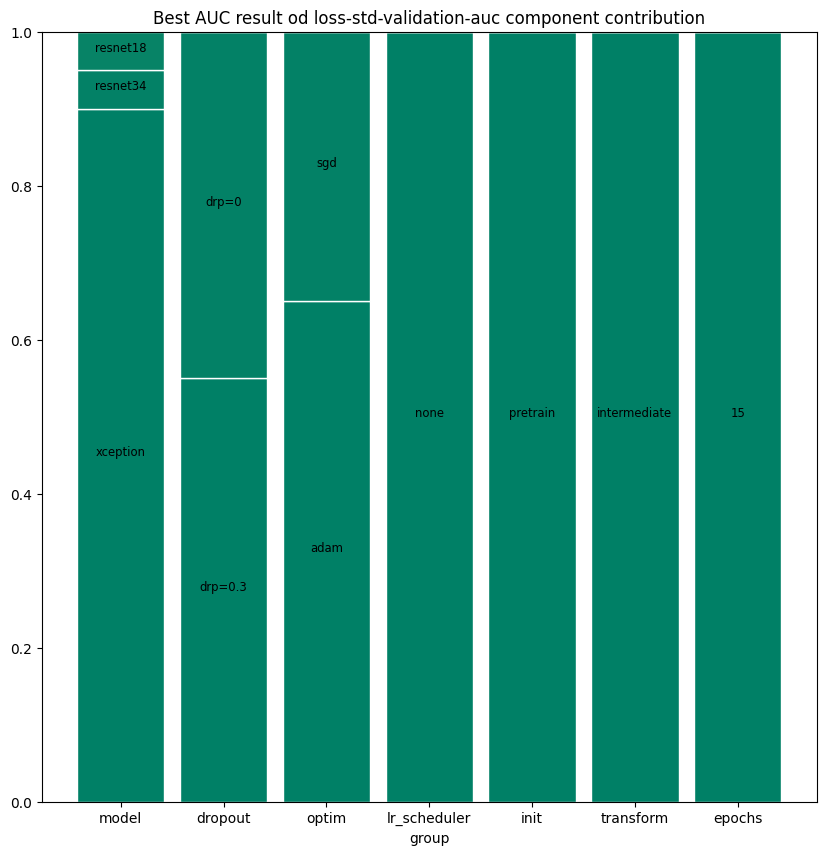

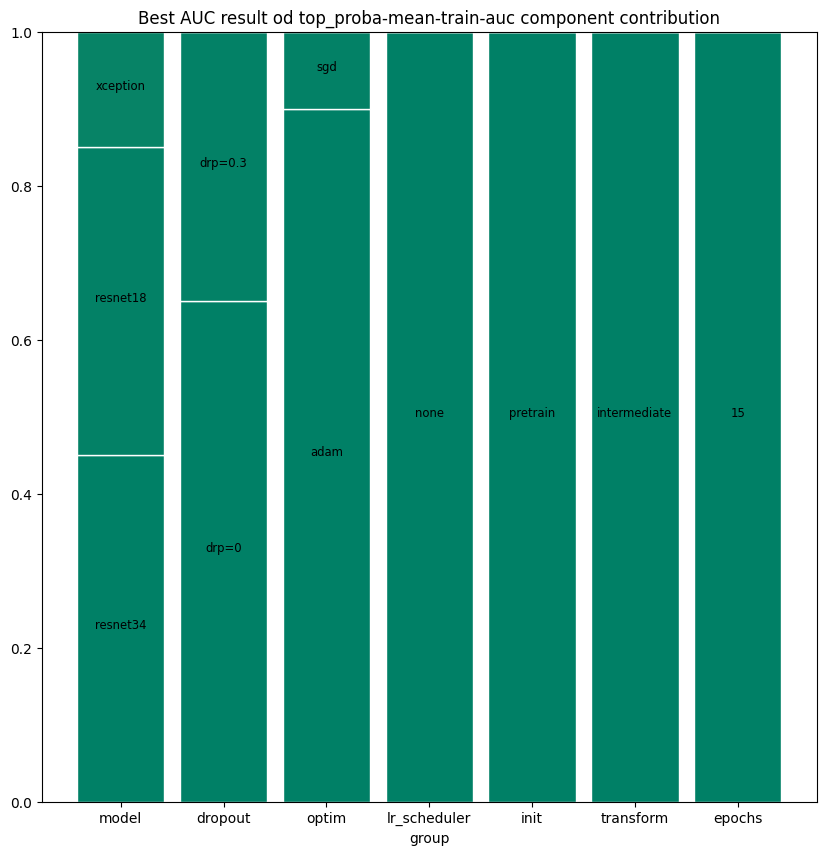

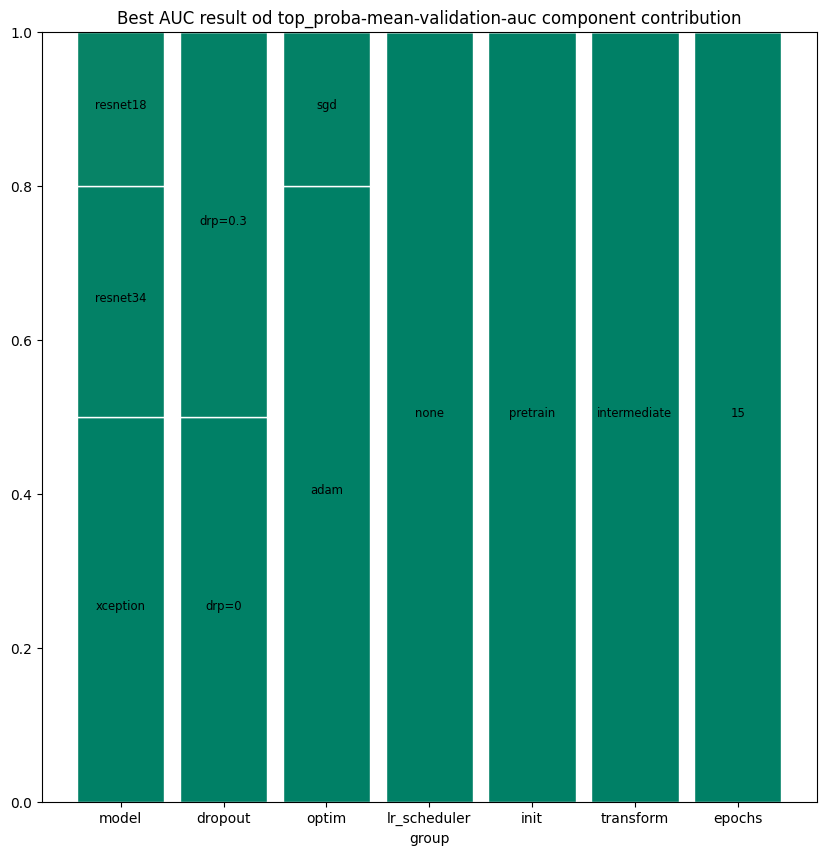

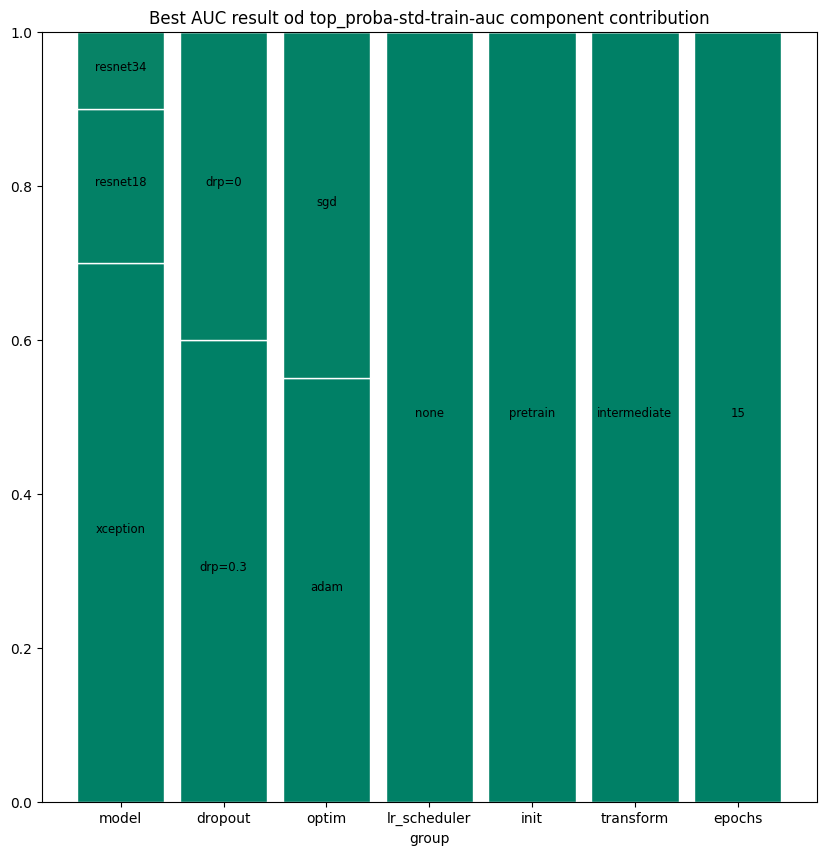

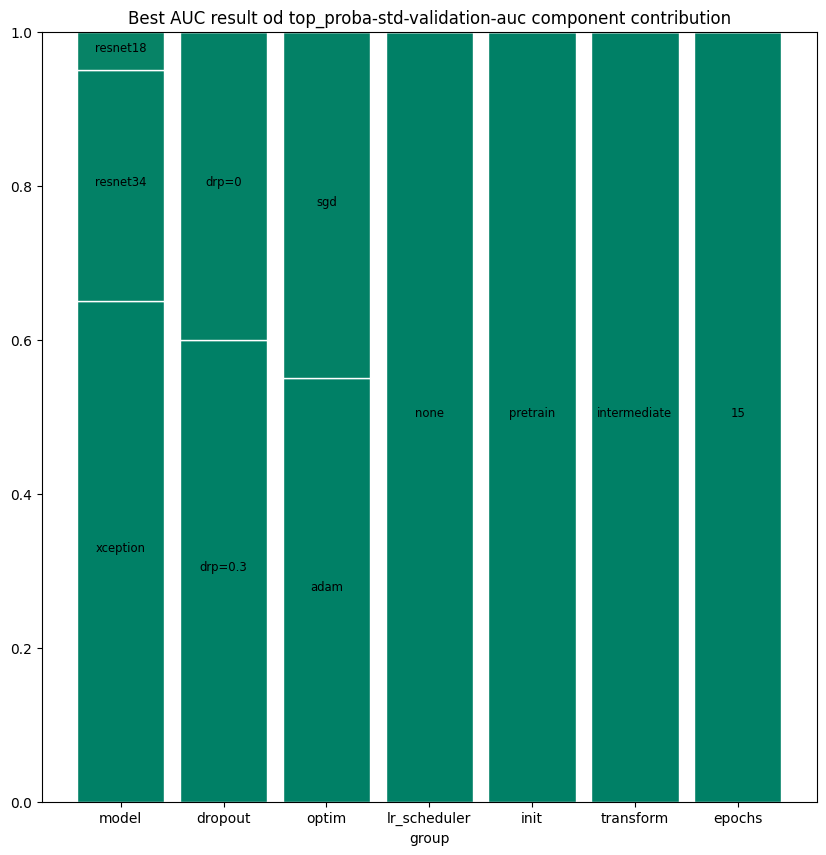

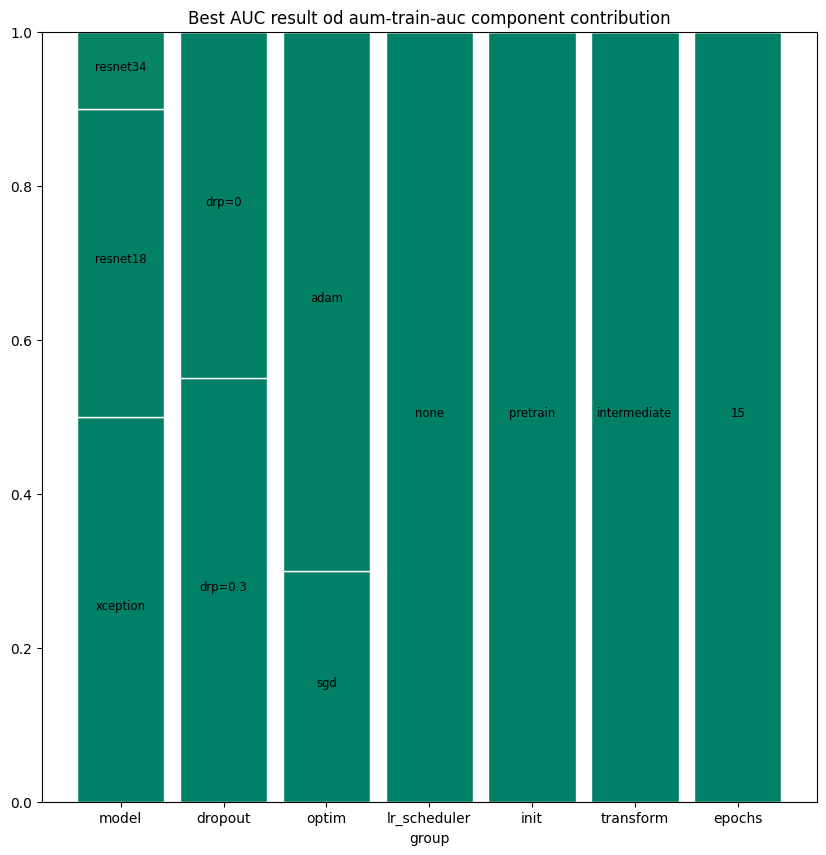

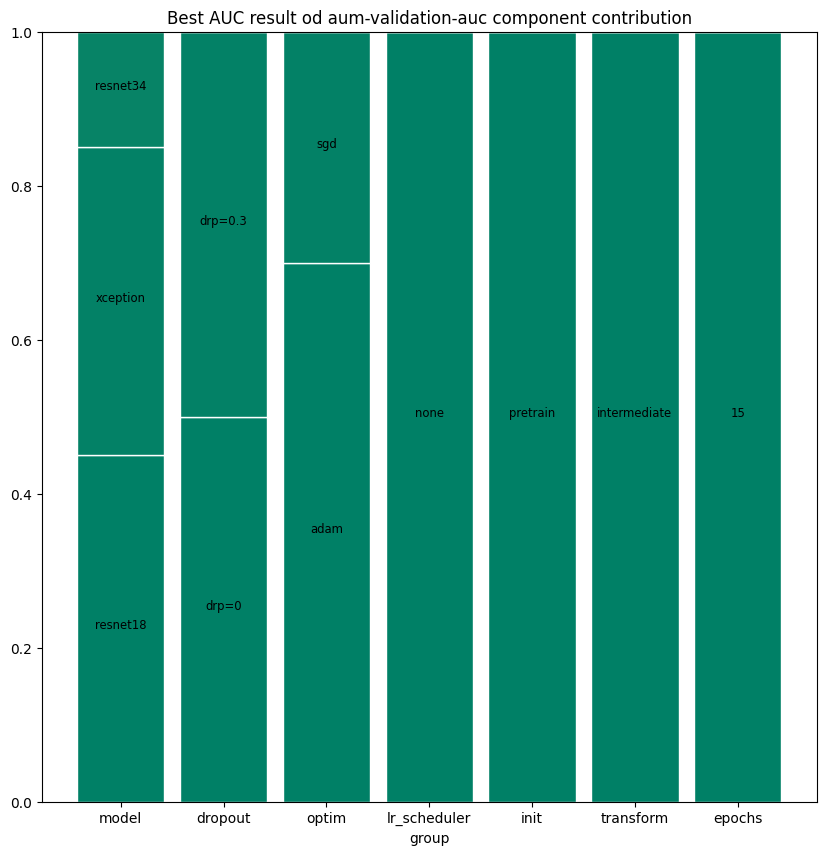

In [7]:
for auc_column_name in merged_metrics_auc.columns:
  if auc_column_name == 'index':
    continue
  metric_name = auc_column_name.split('-')[0]
  
  # Sort the DataFrame by 'auc' column in descending order
  sorted_df = metric_dataframes[metric_name].sort_values(by=auc_column_name, ascending=False)
  # Select the top 20 rows
  top_20_df = sorted_df.head(20).drop(columns=['dataset','lr','np','ns','folds','done','valid','train_loss','validation_loss', 'index'])
  # train_max_auc_rows = train_max_auc_rows[['model', 'optim', 'init', 'lr_scheduler', 'dropout', 'transform']]
  if metric_name in MEANSTD_METRIC:
    prune_columns = 4
  else:
    prune_columns = 2
  draw_stacked_bars(top_20_df.iloc[:, :-prune_columns], colors=colors, title=f"Best AUC result of {auc_column_name} component contribution", figsize=(10,10))